# Embryoscope Data Exploration

This notebook demonstrates how to explore and analyze embryoscope data stored in the DuckDB database.

In [26]:
# Import required libraries
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

## 1. Connect to DuckDB Database

In [27]:
# Connect to the embryoscope database
db_path = "../../database/huntington_data_lake.duckdb"
conn = duckdb.connect(db_path)

print(f"Connected to database: {db_path}")

# List all schemas
print("\n=== Schemas ===")
schemas = conn.execute("SELECT schema_name FROM information_schema.schemata;").fetchall()
for schema in schemas:
    print(f"  - {schema[0]}")

# List all tables
print("\n=== All Tables ===")
tables = conn.execute("SELECT table_name FROM information_schema.tables;").fetchall()
for table in tables:
    print(f"  - {table[0]}")

# List embryoscope schema tables specifically
schema = 'silver_embryoscope'
print(f"\n=== {schema} Schema Tables ===")
embryoscope_tables = conn.execute(f"SELECT table_name FROM information_schema.tables WHERE table_schema = '{schema}';").fetchall()
for table in embryoscope_tables:
    print(f"  - {schema}.{table[0]}")

conn.close()

Connected to database: ../../database/huntington_data_lake.duckdb

=== Schemas ===
  - gold
  - main
  - silver_embryoscope
  - information_schema
  - main
  - pg_catalog
  - main

=== All Tables ===
  - clinisys_embrioes
  - embryoscope_clinisys_combined
  - embryoscope_embrioes
  - embryo_data
  - idascore
  - patients
  - treatments

=== silver_embryoscope Schema Tables ===
  - silver_embryoscope.embryo_data
  - silver_embryoscope.idascore
  - silver_embryoscope.patients
  - silver_embryoscope.treatments


## 2. Database Overview

In [28]:
# Get overview of data in each table
# Open connection
conn = duckdb.connect(db_path)
print("=== Database Overview ===\n")

data_tables = ['patients', 'treatments', 'embryo_data', 'idascore']

# system = 'embryoscope'
schema = 'silver_embryoscope'

for table in data_tables:
    try:
        # Get row count
        count = conn.execute(f"SELECT COUNT(*) FROM {schema}.{table}").fetchone()[0]
        
        # Get latest extraction timestamp
        latest = conn.execute(f"SELECT MAX(_extraction_timestamp) FROM {schema}.{table}").fetchone()[0]
        
        # Get unique locations
        locations = conn.execute(f"SELECT DISTINCT _location FROM {schema}.{table}").fetchall()
        location_list = [loc[0] for loc in locations]
        
        print(f"{table}:")
        print(f"  - Total rows: {count:,}")
        print(f"  - Latest extraction: {latest}")
        print(f"  - Locations: {location_list}")
        print()
        
    except Exception as e:
        print(f"{table}: Error - {e}\n")

# Close connection
conn.close()

=== Database Overview ===



patients:
  - Total rows: 11,847
  - Latest extraction: 2025-07-23 14:56:37.608408
  - Locations: ['Ibirapuera', 'Vila Mariana', 'Belo Horizonte', 'Brasilia']

treatments:
  - Total rows: 16,758
  - Latest extraction: 2025-07-23 14:59:56.066545
  - Locations: ['Brasilia', 'Vila Mariana', 'Belo Horizonte', 'Ibirapuera']

embryo_data:
  - Total rows: 128,453
  - Latest extraction: 2025-07-23 14:59:56.066545
  - Locations: ['Ibirapuera', 'Vila Mariana', 'Belo Horizonte', 'Brasilia']

idascore:
  - Total rows: 9,562
  - Latest extraction: 2025-07-23 14:59:56.043726
  - Locations: ['Vila Mariana']



## 3. Explore Patients Data

In [29]:
conn = duckdb.connect(db_path)
patients_query = f"""
SELECT * FROM  {schema}.patients 
ORDER BY _location, PatientIDx
"""
patients_df = conn.execute(patients_query).df()
conn.close()

print(f"Patients data shape: {patients_df.shape}")
patients_df.head()


Patients data shape: (11847, 10)


,PatientIDx,PatientID,FirstName,LastName,_extraction_timestamp,_location,_run_id,_row_hash,DateOfBirth,unit_huntington
0,NEXTGEN_44153.5200004514,68098,"MENEZES, RENATA GIACOMIN",PG,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,42edf612d4a043534f5b2e218bec9aaf,NaT,Belo Horizonte
1,NEXTGEN_44539.5360013194,67202,"FONSECA, ANNA CAROLINA",FRANKLIN,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,9a4b1a4842035085ca4344489063fcb0,NaT,Belo Horizonte
2,PC10T4JJ12641_43971.4735164352,55510,"LEITE, AMANDA AYUPP GUIMARAES",PG,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,b1c92d0709d0b633220c30d3585485f3,1985-04-01,Belo Horizonte
3,PC10T4JJ12641_43972.4462907292,63702,"SILVA, IRIS PATRICIA MESQUITA",DA,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,36e47420e80631bf09f37593f08e3c8b,1977-09-01,Belo Horizonte
4,PC10T4JJ12641_43974.4114913542,58834,"SOUZA, SORAIA",FELIX,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,46ed05b72bbe903763f8bcb7394ce091,1985-02-01,Belo Horizonte


In [30]:
patients_df

,PatientIDx,PatientID,FirstName,LastName,_extraction_timestamp,_location,_run_id,_row_hash,DateOfBirth,unit_huntington
0,NEXTGEN_44153.5200004514,68098,"MENEZES, RENATA GIACOMIN",PG,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,42edf612d4a043534f5b2e218bec9aaf,NaT,Belo Horizonte
1,NEXTGEN_44539.5360013194,67202,"FONSECA, ANNA CAROLINA",FRANKLIN,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,9a4b1a4842035085ca4344489063fcb0,NaT,Belo Horizonte
2,PC10T4JJ12641_43971.4735164352,55510,"LEITE, AMANDA AYUPP GUIMARAES",PG,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,b1c92d0709d0b633220c30d3585485f3,1985-04-01,Belo Horizonte
3,PC10T4JJ12641_43972.4462907292,63702,"SILVA, IRIS PATRICIA MESQUITA",DA,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,36e47420e80631bf09f37593f08e3c8b,1977-09-01,Belo Horizonte
4,PC10T4JJ12641_43974.4114913542,58834,"SOUZA, SORAIA",FELIX,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,46ed05b72bbe903763f8bcb7394ce091,1985-02-01,Belo Horizonte
...,...,...,...,...,...,...,...,...,...,...
11842,PC1R85KM_45857.3863698380,816060,"ALMEIDA, ZARA C.",20/08/1980,2025-07-22 21:29:15.137265,Vila Mariana,3967b75e-be46-44b7-ae15-93e25b9eb460,6c1ead16fc85bcd965662c8c80787ed9,1980-08-20,Vila Mariana
11843,PC1R85KM_45859.4513730093,891309,"PINTO, BARBARA MARIANE EPIFANI",18/11/1981,2025-07-22 21:29:15.137265,Vila Mariana,3967b75e-be46-44b7-ae15-93e25b9eb460,c54c11e81a456b77f52b12a535cad25f,1981-11-18,Vila Mariana
11844,PC1R85KM_45860.6726285995,833901,"PINHEIRO, ANA PAULA YAMAGUTI",11/11/1983,2025-07-22 21:29:15.137265,Vila Mariana,3967b75e-be46-44b7-ae15-93e25b9eb460,4aab903cc19aa0b1118e4e56eb5d6841,1983-11-11,Vila Mariana
11845,PC1R85KM_45861.4523150347,889193,"MOTA, NEIDE MOREIRA",22/01/1976,2025-07-23 14:56:37.502885,Vila Mariana,e1650424-a3a6-489d-9e2e-27612a7b2c2b,d647ee1ff4ff8fc8e91200fee2a6e830,1976-01-22,Vila Mariana


In [31]:
patients_df['DateOfBirth'].value_counts(dropna=False)

DateOfBirth
NaT           422
1979-03-01     39
1978-01-01     37
1981-11-01     36
1981-06-01     36
             ... 
1990-08-31      1
1979-04-10      1
1987-11-19      1
1988-09-30      1
1984-11-13      1
Name: count, Length: 4669, dtype: int64

Patients by location:
_location
Ibirapuera        5272
Vila Mariana      2654
Belo Horizonte    2263
Brasilia          1658
Name: count, dtype: int64


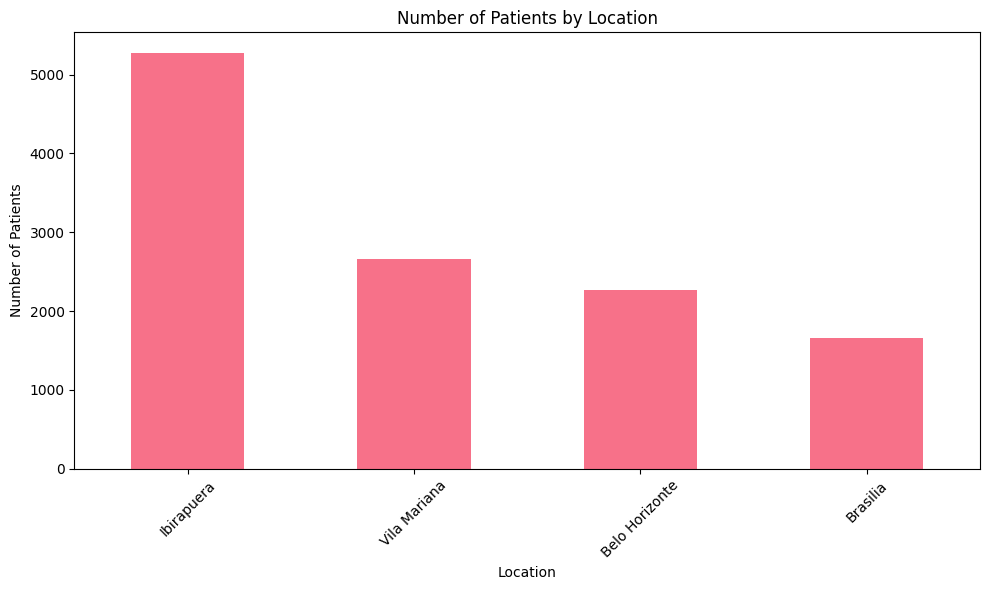

In [32]:
# Patients by location
patients_by_location = patients_df['_location'].value_counts()
print("Patients by location:")
print(patients_by_location)

# Plot patients by location
plt.figure(figsize=(10, 6))
patients_by_location.plot(kind='bar')
plt.title('Number of Patients by Location')
plt.xlabel('Location')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Explore Treatments Data

In [33]:
conn = duckdb.connect(db_path)

# Get latest treatments data
treatments_query = f"""
SELECT * FROM {schema}.treatments 
ORDER BY _location, PatientIDx
"""

treatments_df = conn.execute(treatments_query).df()
conn.close()

print(f"Treatments data shape: {treatments_df.shape}")
treatments_df.head()

Treatments data shape: (16758, 7)


,PatientIDx,TreatmentName,_extraction_timestamp,_location,_run_id,_row_hash,unit_huntington
0,NEXTGEN_44153.5200004514,18/11/2020,2025-07-16 09:52:05.198485,Belo Horizonte,0c6e13e8-5703-46f6-a6b8-f48d7c4e1ebc,7490c267ccf8b6caf727d99e8299da54,Belo Horizonte
1,NEXTGEN_44539.5360013194,09/12/2021,2025-07-16 09:52:05.198485,Belo Horizonte,0c6e13e8-5703-46f6-a6b8-f48d7c4e1ebc,935dd1a9c308368240b7cb5e010ef1bb,Belo Horizonte
2,PC10T4JJ12641_43971.4735164352,20/05/2020,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,54b9c4d153445f7c4c988a155fc38399,Belo Horizonte
3,PC10T4JJ12641_43972.4462907292,21/05/2020,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,0e9cbb85e93b16e4be0d256569d104ed,Belo Horizonte
4,PC10T4JJ12641_43974.4114913542,23/05/2020,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,10d0ee9ed812eca306d469fd3c9e1a01,Belo Horizonte


Treatments by location:
_location
Ibirapuera        8018
Vila Mariana      3541
Belo Horizonte    2937
Brasilia          2262
Name: count, dtype: int64

Treatments per patient:
count    11889.000000
mean         1.409538
std          0.875443
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         23.000000
dtype: float64


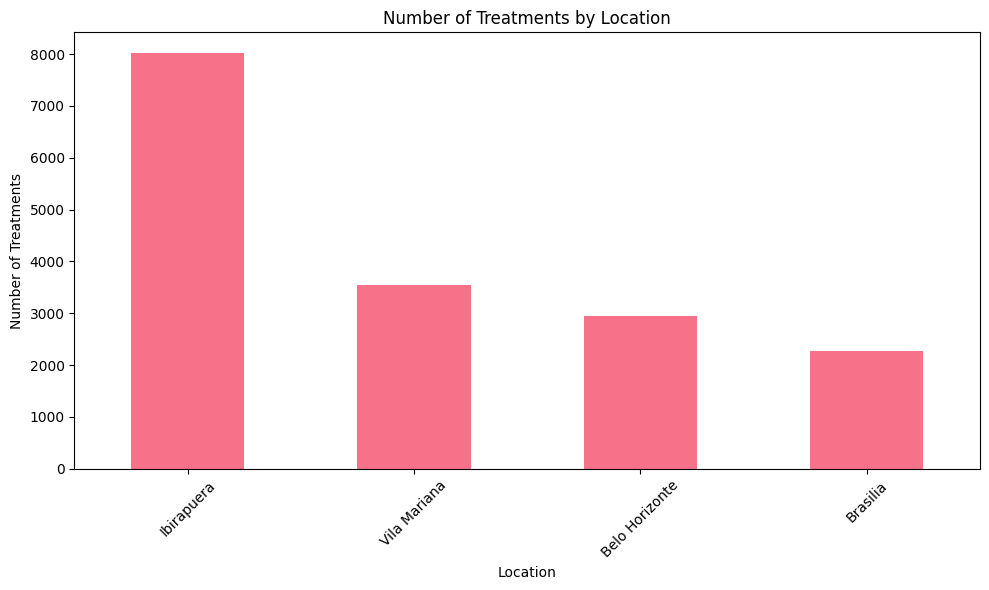

In [34]:
# Treatments analysis
print("Treatments by location:")
treatments_by_location = treatments_df['_location'].value_counts()
print(treatments_by_location)

print("\nTreatments per patient:")
treatments_per_patient = treatments_df.groupby(['_location', 'PatientIDx']).size()
print(treatments_per_patient.describe())

# Plot treatments by location
plt.figure(figsize=(10, 6))
treatments_by_location.plot(kind='bar')
plt.title('Number of Treatments by Location')
plt.xlabel('Location')
plt.ylabel('Number of Treatments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Explore Embryo Data

In [35]:
conn = duckdb.connect(db_path)

# Get latest embryo data
embryo_query = f"""
SELECT * FROM  {schema}.embryo_data 
ORDER BY _location, EmbryoID
"""

embryo_df = conn.execute(embryo_query).df()
conn.close()

print(f"Embryo data shape: {embryo_df.shape}")
embryo_df.head()



Embryo data shape: (128453, 16)


,PatientIDx,TreatmentName,EmbryoDescriptionID,_extraction_timestamp,_location,_run_id,_row_hash,EmbryoID,KIDDate,KIDVersion,KIDUser,KIDScore,FertilizationTime,EmbryoFate,WellNumber,embryo_number
0,PC10T4JJ55173_43629.4403575000,13/06/2019,AA1,2025-07-16 09:52:05.198485,Belo Horizonte,0c6e13e8-5703-46f6-a6b8-f48d7c4e1ebc,1e2baedd7a89237acea4cb405574ca80,D2019.06.13_S00021_I3254_P-1,2019-06-14,KIDScore D3 v1.1,ADMIN,NA,2019-06-13 12:00:00,Freeze,1,1
1,PC10T4JJ55173_43629.4403575000,13/06/2019,AA2,2025-07-16 09:52:05.198485,Belo Horizonte,0c6e13e8-5703-46f6-a6b8-f48d7c4e1ebc,ca6a1dc93183118152225b3797c79342,D2019.06.13_S00021_I3254_P-2,2019-06-14,KIDScore D3 v1.1,ADMIN,NA,2019-06-13 12:00:00,Avoid,2,2
2,PC10T4JJ55173_43629.4403575000,13/06/2019,AA3,2025-07-16 09:52:05.198485,Belo Horizonte,0c6e13e8-5703-46f6-a6b8-f48d7c4e1ebc,11a3c32d4dbeb84a4dc128d30c30e1af,D2019.06.13_S00021_I3254_P-3,2019-06-14,KIDScore D3 v1.1,ADMIN,NA,2019-06-13 12:00:00,Freeze,3,3
3,PC10T4JJ55173_43629.4403575000,13/06/2019,AA4,2025-07-16 09:52:05.198485,Belo Horizonte,0c6e13e8-5703-46f6-a6b8-f48d7c4e1ebc,9af17b05d4c3168b4783daeaa5ccf464,D2019.06.13_S00021_I3254_P-4,2019-06-14,KIDScore D3 v1.1,ADMIN,NA,2019-06-13 12:00:00,Avoid,4,4
4,PC10T4JJ55173_43629.4403575000,13/06/2019,AA5,2025-07-16 09:52:05.198485,Belo Horizonte,0c6e13e8-5703-46f6-a6b8-f48d7c4e1ebc,b089ee3a8da38c1bcfeaa34e4dbae64d,D2019.06.13_S00021_I3254_P-5,2019-06-14,KIDScore D3 v1.1,ADMIN,NA,2019-06-13 12:00:00,Avoid,5,5


Embryos by location:
_location
Ibirapuera        57605
Vila Mariana      30809
Belo Horizonte    22682
Brasilia          17357
Name: count, dtype: int64

Embryo fates:
EmbryoFate
Avoid                   69557
Freeze                  38244
Unknown                 10487
FrozenEmbryoTransfer     6525
Transfer                 3019
Undecided                 621
Name: count, dtype: int64


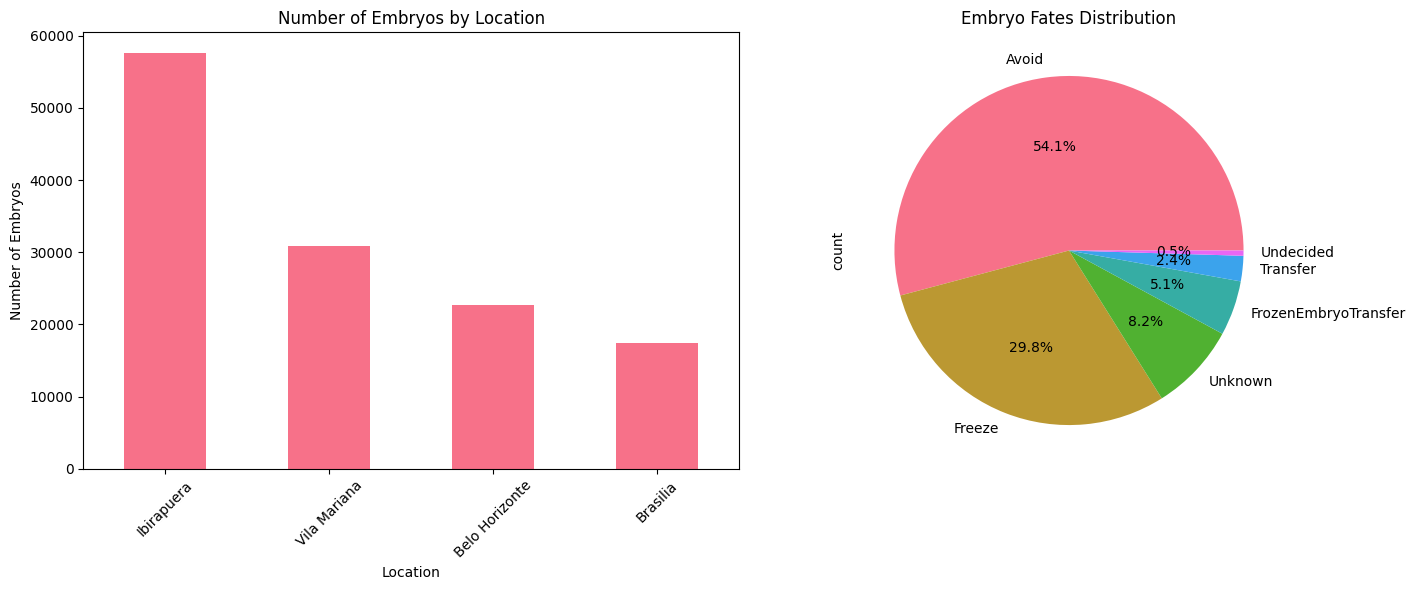

In [36]:
# Embryo analysis
print("Embryos by location:")
embryos_by_location = embryo_df['_location'].value_counts()
print(embryos_by_location)

print("\nEmbryo fates:")
embryo_fates = embryo_df['EmbryoFate'].value_counts()
print(embryo_fates)

# Plot embryos by location
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

embryos_by_location.plot(kind='bar', ax=ax1)
ax1.set_title('Number of Embryos by Location')
ax1.set_xlabel('Location')
ax1.set_ylabel('Number of Embryos')
ax1.tick_params(axis='x', rotation=45)

embryo_fates.plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Embryo Fates Distribution')

plt.tight_layout()
plt.show()

## 6. Explore IDA Score Data

In [37]:
conn = duckdb.connect(db_path)

# Get latest IDA score data
idascore_query = f"""
SELECT * FROM  {schema}.idascore 
ORDER BY _location, EmbryoID
"""

idascore_df = conn.execute(idascore_query).df()
conn.close()

print(f"IDA Score data shape: {idascore_df.shape}")
idascore_df.head()


IDA Score data shape: (9562, 10)


,EmbryoID,IDAScore,IDATime,IDAVersion,IDATimestamp,_extraction_timestamp,_location,_run_id,_row_hash,unit_huntington
0,D2019.06.19_S00028_I3253_P-1,1.03,115,2.0.4,2024.04.30 07:55:37,2025-07-15 19:21:41.460065,Vila Mariana,5a1a0509-7c67-43d2-a882-27ef8fcbf469,212cbf29a4c410bb654943824050d577,Vila Mariana
1,D2019.06.19_S00028_I3253_P-2,1.05,115,2.0.4,2024.04.30 07:55:35,2025-07-15 19:21:41.460065,Vila Mariana,5a1a0509-7c67-43d2-a882-27ef8fcbf469,87d5649e334849ef00382e85bf0d479c,Vila Mariana
2,D2019.06.19_S00028_I3253_P-3,1.06,115,2.0.4,2024.04.30 07:55:33,2025-07-15 19:21:41.460065,Vila Mariana,5a1a0509-7c67-43d2-a882-27ef8fcbf469,04ba8020f5111c86dca22000e6e8736e,Vila Mariana
3,D2019.06.19_S00028_I3253_P-4,1.01,115,2.0.4,2024.04.30 07:56:06,2025-07-15 19:21:41.460065,Vila Mariana,5a1a0509-7c67-43d2-a882-27ef8fcbf469,3951e556b9a198c43620aba73ee02db4,Vila Mariana
4,D2019.07.03_S00054_I3253_P-11,8.15,120,2.0.4,2024.05.28 15:20:09,2025-07-15 19:21:41.460065,Vila Mariana,5a1a0509-7c67-43d2-a882-27ef8fcbf469,64fd55ee987af775ee05eb47cf1c8bf7,Vila Mariana


IDA Scores by location:
_location
Vila Mariana    9562
Name: count, dtype: int64

Score statistics:
count     9562
unique     848
top       1.01
freq       678
Name: IDAScore, dtype: object

Viability distribution:
IDAScore
1.01    678
1.05    413
1.04    398
1.0     351
1.06    334
       ... 
8.92      1
4.19      1
6.82      1
9.66      1
7.81      1
Name: count, Length: 848, dtype: int64


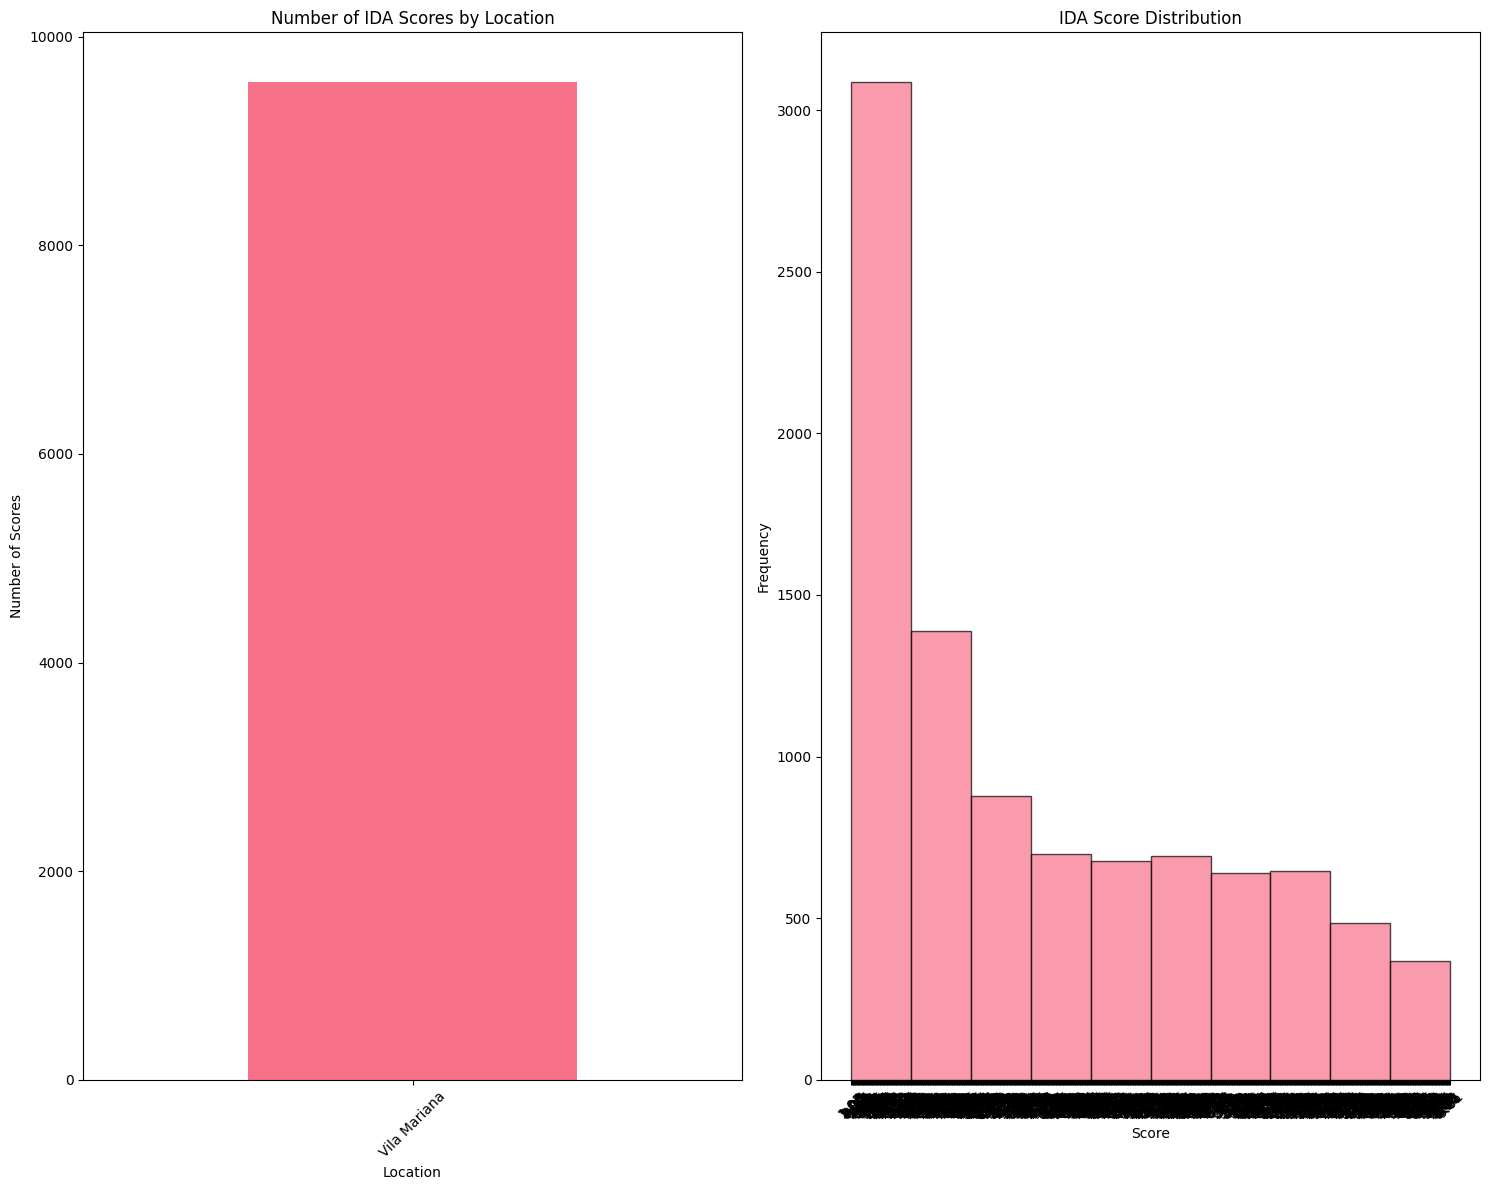

In [38]:
# IDA Score analysis
print("IDA Scores by location:")
idascore_by_location = idascore_df['_location'].value_counts()
print(idascore_by_location)

print("\nScore statistics:")
print(idascore_df['IDAScore'].describe())

print("\nViability distribution:")
viability_dist = idascore_df['IDAScore'].value_counts()
print(viability_dist)

# Plot IDA scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 12))

# Scores by location
idascore_by_location.plot(kind='bar', ax=ax1)
ax1.set_title('Number of IDA Scores by Location')
ax1.set_xlabel('Location')
ax1.set_ylabel('Number of Scores')
ax1.tick_params(axis='x', rotation=45)

# Score distribution
ax2.hist(idascore_df['IDAScore'].dropna(), bins=10, alpha=0.7, edgecolor='black')
ax2.set_title('IDA Score Distribution')
ax2.set_xlabel('Score')
ax2.set_ylabel('Frequency')
for ax in [ax1, ax2]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

## 7. Combined Analysis

In [48]:
conn = duckdb.connect(db_path)

# Create a comprehensive view combining all data
comprehensive_query = f"""
WITH latest_patients AS (
SELECT * FROM  {schema}.patients 
--    WHERE _extraction_timestamp = (SELECT MAX(_extraction_timestamp) FROM  embryoscope.data_patients)
),
latest_treatments AS (
    SELECT * FROM {schema}.treatments 
--     WHERE _extraction_timestamp = (SELECT MAX(_extraction_timestamp) FROM embryoscope.data_treatments)
),
latest_embryos AS (
    SELECT * FROM {schema}.embryo_data 
--     WHERE _extraction_timestamp = (SELECT MAX(_extraction_timestamp) FROM embryoscope.data_embryo_data)
),
-- Table data_idascore does not exist, so we cannot include latest_scores.
-- If/when the table is created, restore this CTE:
latest_scores AS (
   SELECT * FROM {schema}.idascore 
--     WHERE _extraction_timestamp = (SELECT MAX(_extraction_timestamp) FROM embryoscope.data_idascore)
)
SELECT 
    e.*,
    p.FirstName as PatientName,
    p.DateOfBirth,
    s.IDAScore
FROM latest_embryos e
LEFT JOIN latest_patients p ON e.PatientIDx = p.PatientIDx AND e._location = p._location
LEFT JOIN latest_scores s ON e.EmbryoID = s.EmbryoID AND e._location = s._location
WHERE p.PatientID = '161746'
ORDER BY e._location, e.PatientIDx, e.EmbryoID
"""

comprehensive_df = conn.execute(comprehensive_query).df()
conn.close()

print(f"Comprehensive data shape: {comprehensive_df.shape}")
comprehensive_df.head()

Comprehensive data shape: (13, 19)


,PatientIDx,TreatmentName,EmbryoDescriptionID,_extraction_timestamp,_location,_run_id,_row_hash,EmbryoID,KIDDate,KIDVersion,KIDUser,KIDScore,FertilizationTime,EmbryoFate,WellNumber,embryo_number,PatientName,DateOfBirth,IDAScore
0,PC1P7BHG_45850.4034504514,2025 - 1433,AA1,2025-07-18 11:39:00.485205,Ibirapuera,c79200ae-c8af-425e-b7cb-0b25a5ee842e,b56fc179a1cc8d60ca0eadfd7de72c04,D2025.07.12_S04193_I3027_P-1,2025-07-18,KIDScoreD5 v3.3,ADMIN,NA,2025-07-12 11:35:00,Avoid,1,1,"TRAMONTIN, FRANCIELE M.",1988-03-24,None
1,PC1P7BHG_45850.4034504514,2025 - 1433,AA2,2025-07-18 11:39:00.485205,Ibirapuera,c79200ae-c8af-425e-b7cb-0b25a5ee842e,e076fa2299982b410177a1c9dbea0f77,D2025.07.12_S04193_I3027_P-2,2025-07-18,KIDScoreD5 v3.3,ADMIN,NA,2025-07-12 11:35:00,Avoid,2,2,"TRAMONTIN, FRANCIELE M.",1988-03-24,None
2,PC1P7BHG_45850.4034504514,2025 - 1433,AA3,2025-07-18 11:39:00.485205,Ibirapuera,c79200ae-c8af-425e-b7cb-0b25a5ee842e,f2953dbb244c68bfccb6606704adf9d0,D2025.07.12_S04193_I3027_P-3,2025-07-18,KIDScoreD5 v3.3,ADMIN,NA,2025-07-12 11:35:00,Avoid,3,3,"TRAMONTIN, FRANCIELE M.",1988-03-24,None
3,PC1P7BHG_45850.4034504514,2025 - 1433,AA4,2025-07-18 11:39:00.485205,Ibirapuera,c79200ae-c8af-425e-b7cb-0b25a5ee842e,9daddb64eb8860d2fb13248a25aa8cf6,D2025.07.12_S04193_I3027_P-4,2025-07-18,KIDScoreD5 v3.3,ADMIN,NA,2025-07-12 11:35:00,Avoid,4,4,"TRAMONTIN, FRANCIELE M.",1988-03-24,None
4,PC1P7BHG_45850.4034504514,2025 - 1433,AA5,2025-07-18 11:39:00.485205,Ibirapuera,c79200ae-c8af-425e-b7cb-0b25a5ee842e,938e58833a2164259e5d14ffa22b4446,D2025.07.12_S04193_I3027_P-5,2025-07-18,KIDScoreD5 v3.3,ADMIN,NA,2025-07-12 11:35:00,Avoid,5,5,"TRAMONTIN, FRANCIELE M.",1988-03-24,None


In [40]:
comprehensive_df[[
    'EmbryoID', 'TreatmentName',
    'FertilizationTime', 'TreatmentName', 'EmbryoFate', 'EmbryoDescriptionID', 'WellNumber', 
    'embryo_number']].sort_values(by='embryo_number')

,EmbryoID,TreatmentName,FertilizationTime,TreatmentName,EmbryoFate,EmbryoDescriptionID,WellNumber,embryo_number
0,D2025.07.18_S03646_I3253_P-1,2025 - 1233,2025-07-18 10:40:00,2025 - 1233,Unknown,AA1,1,1
8,D2025.07.18_S03646_I3253_P-2,2025 - 1233,2025-07-18 10:40:00,2025 - 1233,Unknown,AA2,2,2
9,D2025.07.18_S03646_I3253_P-3,2025 - 1233,2025-07-18 10:40:00,2025 - 1233,Avoid,AA3,3,3
10,D2025.07.18_S03646_I3253_P-4,2025 - 1233,2025-07-18 10:40:00,2025 - 1233,Unknown,AA4,4,4
11,D2025.07.18_S03646_I3253_P-5,2025 - 1233,2025-07-18 10:40:00,2025 - 1233,Unknown,AA5,5,5
12,D2025.07.18_S03646_I3253_P-6,2025 - 1233,2025-07-18 10:40:00,2025 - 1233,Avoid,AA6,6,6
13,D2025.07.18_S03646_I3253_P-7,2025 - 1233,2025-07-18 10:40:00,2025 - 1233,Unknown,AA7,7,7
14,D2025.07.18_S03646_I3253_P-8,2025 - 1233,2025-07-18 10:40:00,2025 - 1233,Unknown,AA8,8,8
15,D2025.07.18_S03646_I3253_P-9,2025 - 1233,2025-07-18 10:40:00,2025 - 1233,Avoid,AA9,9,9
1,D2025.07.18_S03646_I3253_P-10,2025 - 1233,2025-07-18 10:40:00,2025 - 1233,Unknown,AA10,10,10


In [41]:
comprehensive_df.loc[comprehensive_df['EmbryoFate']!='Avoid', [
    'EmbryoID', 'TreatmentName','FertilizationTime','EmbryoFate', 
    'EmbryoDescriptionID', 'WellNumber', 'embryo_number']].sort_values(by='embryo_number')

,EmbryoID,TreatmentName,FertilizationTime,EmbryoFate,EmbryoDescriptionID,WellNumber,embryo_number
0,D2025.07.18_S03646_I3253_P-1,2025 - 1233,2025-07-18 10:40:00,Unknown,AA1,1,1
8,D2025.07.18_S03646_I3253_P-2,2025 - 1233,2025-07-18 10:40:00,Unknown,AA2,2,2
10,D2025.07.18_S03646_I3253_P-4,2025 - 1233,2025-07-18 10:40:00,Unknown,AA4,4,4
11,D2025.07.18_S03646_I3253_P-5,2025 - 1233,2025-07-18 10:40:00,Unknown,AA5,5,5
13,D2025.07.18_S03646_I3253_P-7,2025 - 1233,2025-07-18 10:40:00,Unknown,AA7,7,7
14,D2025.07.18_S03646_I3253_P-8,2025 - 1233,2025-07-18 10:40:00,Unknown,AA8,8,8
1,D2025.07.18_S03646_I3253_P-10,2025 - 1233,2025-07-18 10:40:00,Unknown,AA10,10,10
2,D2025.07.18_S03646_I3253_P-11,2025 - 1233,2025-07-18 10:40:00,Unknown,AA11,11,11
3,D2025.07.18_S03646_I3253_P-12,2025 - 1233,2025-07-18 10:40:00,Unknown,AA12,12,12
5,D2025.07.18_S03646_I3253_P-14,2025 - 1233,2025-07-18 10:40:00,Unknown,AA14,14,14


Summary by Location:
              Unique_Patients  Unique_Treatments  Total_Embryos  Mean_Score  \
_location                                                                     
Vila Mariana                1                  1             21       2.232   

              Std_Score  Scored_Embryos  Viable_Embryos  Viability_Rate  
_location                                                                
Vila Mariana      3.149              19               0             0.0  


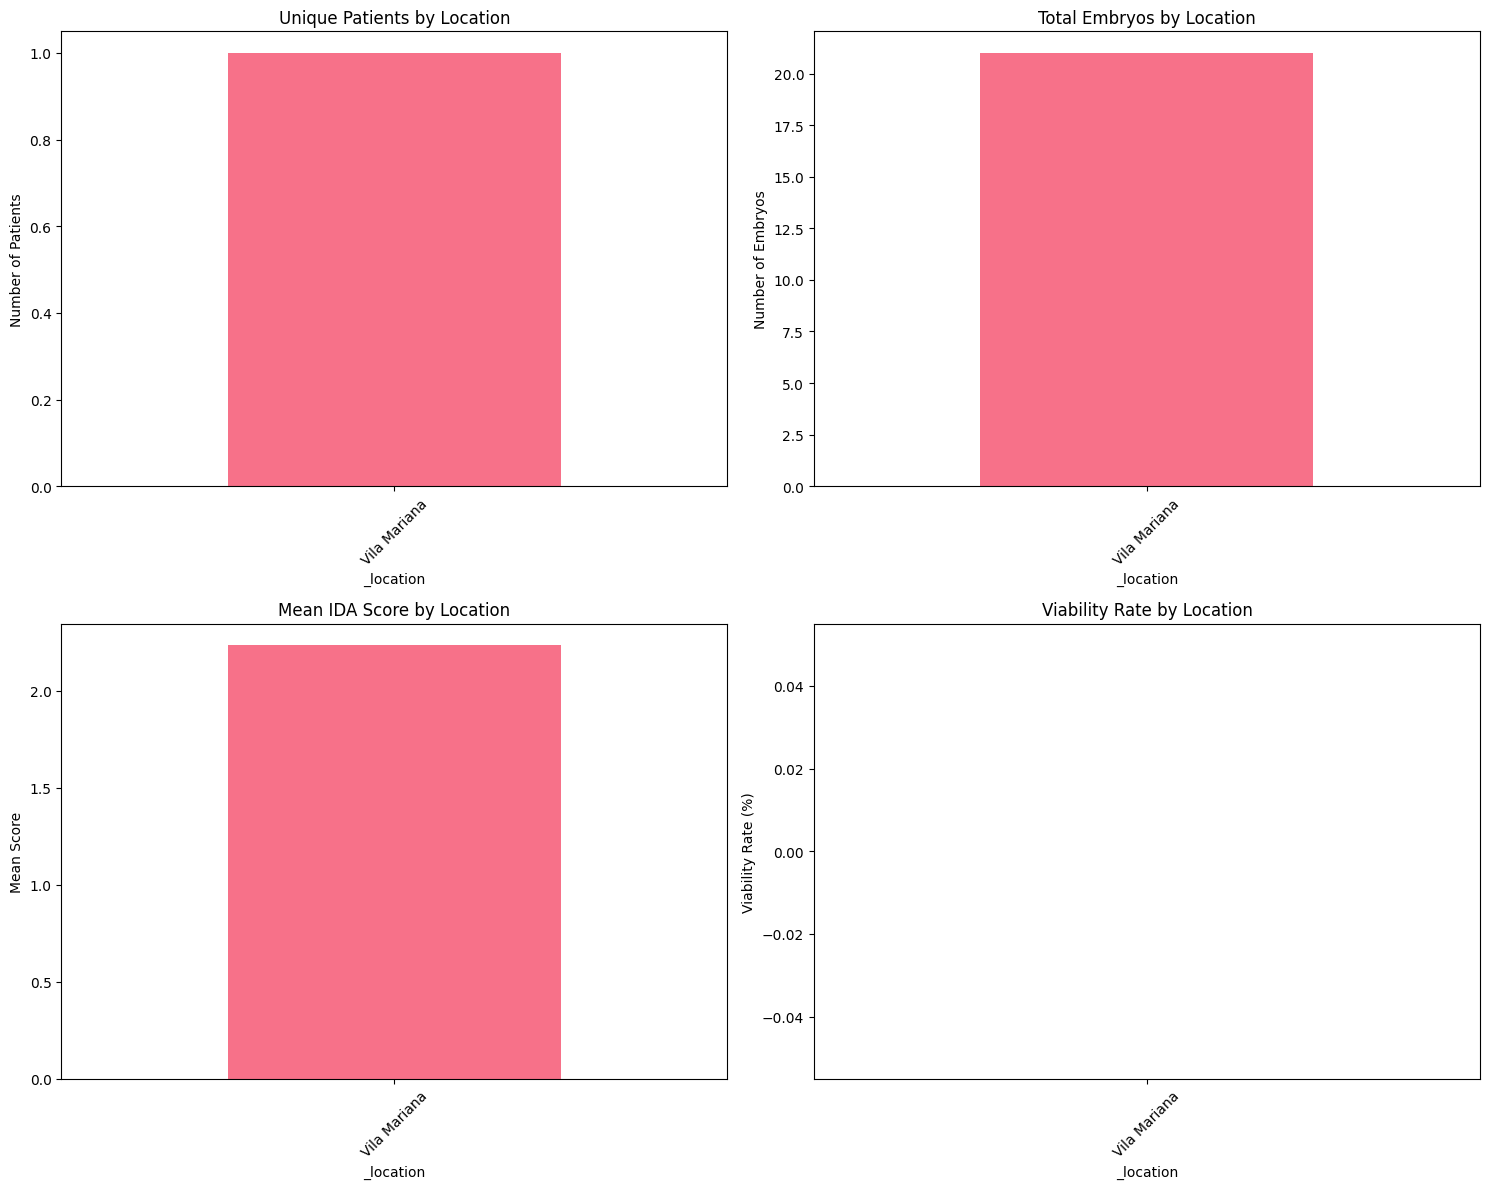

In [42]:
# Summary statistics by location using proper column names
# We'll use: 
#   - 'PatientIDx' for unique patients
#   - 'TreatmentName' for unique treatments
#   - 'EmbryoID' for total embryos
#   - 'KIDScore' for mean/std/count (if numeric)
#   - 'IDAScore' for viable embryos (if 'Viable' is a value)
# If 'KIDScore' is not numeric, skip mean/std.

# Ensure KIDScore is numeric if possible
if comprehensive_df['KIDScore'].dtype == object:
    try:
        comprehensive_df['KIDScore'] = pd.to_numeric(comprehensive_df['KIDScore'], errors='coerce')
    except Exception:
        pass

location_summary = comprehensive_df.groupby('_location').agg(
    Unique_Patients=('PatientIDx', 'nunique'),
    Unique_Treatments=('TreatmentName', 'nunique'),
    Total_Embryos=('EmbryoID', 'count'),
    Mean_Score=('KIDScore', 'mean'),
    Std_Score=('KIDScore', 'std'),
    Scored_Embryos=('KIDScore', 'count'),
    Viable_Embryos=('IDAScore', lambda x: (x == 'Viable').sum())
).round(3)

location_summary['Viability_Rate'] = (location_summary['Viable_Embryos'] / location_summary['Total_Embryos'] * 100).round(1)
location_summary = comprehensive_df.groupby('_location').agg({
    'PatientIDx': 'nunique',
    'TreatmentName': 'nunique',
    'EmbryoID': 'count',
    'KIDScore': ['mean', 'std', 'count'],
    'IDAScore': lambda x: (x == 'Viable').sum()
}).round(3)

location_summary.columns = ['Unique_Patients', 'Unique_Treatments', 'Total_Embryos', 
                           'Mean_Score', 'Std_Score', 'Scored_Embryos', 'Viable_Embryos']
location_summary['Viability_Rate'] = (location_summary['Viable_Embryos'] / location_summary['Total_Embryos'] * 100).round(1)

print("Summary by Location:")
print(location_summary)

# Plot summary
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Patients by location
location_summary['Unique_Patients'].plot(kind='bar', ax=ax1)
ax1.set_title('Unique Patients by Location')
ax1.set_ylabel('Number of Patients')
ax1.tick_params(axis='x', rotation=45)

# Embryos by location
location_summary['Total_Embryos'].plot(kind='bar', ax=ax2)
ax2.set_title('Total Embryos by Location')
ax2.set_ylabel('Number of Embryos')
ax2.tick_params(axis='x', rotation=45)

# Mean scores by location
location_summary['Mean_Score'].plot(kind='bar', ax=ax3)
ax3.set_title('Mean IDA Score by Location')
ax3.set_ylabel('Mean Score')
ax3.tick_params(axis='x', rotation=45)

# Viability rate by location
location_summary['Viability_Rate'].plot(kind='bar', ax=ax4)
ax4.set_title('Viability Rate by Location')
ax4.set_ylabel('Viability Rate (%)')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Time Series Analysis

Time series data:
  extraction_date       _location  daily_embryos
0      2025-07-15        Brasilia          17357
1      2025-07-15      Ibirapuera          57126
2      2025-07-15    Vila Mariana          30500
3      2025-07-16  Belo Horizonte          22501
4      2025-07-16      Ibirapuera             24


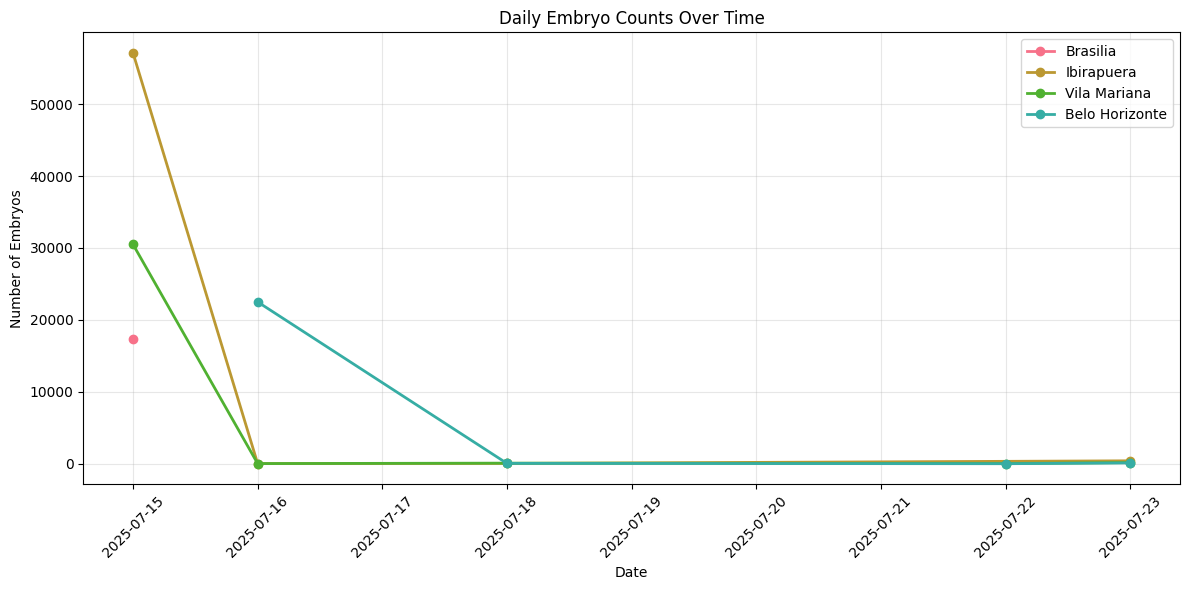

In [43]:
conn = duckdb.connect(db_path)

# Analyze data over time
time_series_query =f"""
SELECT 
    DATE(_extraction_timestamp) as extraction_date,
    _location,
    COUNT(*) as daily_embryos
FROM {schema}.embryo_data
GROUP BY DATE(_extraction_timestamp), _location
ORDER BY extraction_date, _location
"""

time_series_df = conn.execute(time_series_query).df()
conn.close()


time_series_df['extraction_date'] = pd.to_datetime(time_series_df['extraction_date'])

print("Time series data:")
print(time_series_df.head())

# Plot time series
plt.figure(figsize=(12, 6))
for location in time_series_df['_location'].unique():
    location_data = time_series_df[time_series_df['_location'] == location]
    plt.plot(location_data['extraction_date'], location_data['daily_embryos'], 
             marker='o', label=location, linewidth=2)

plt.title('Daily Embryo Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Embryos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9. Custom Queries

In [44]:
# conn = duckdb.connect(db_path)

# # Example: Find high-quality embryos
# high_quality_query = f"""
# SELECT 
#     e.EmbryoID,
#     e.PatientIDx,
#     e.TreatmentName,
#     e.EmbryoFate,
#     e._location,
#     e.KIDScore,
#     e.IDAScore
# FROM {schema}.embryo_data e
# JOIN {schema}.idascore s ON e.EmbryoID = s.EmbryoID AND e._location = s._location
# WHERE e.KIDScore >= 0.8 AND e.IDAScore >= 5
#   --AND e._extraction_timestamp = (SELECT MAX(_extraction_timestamp) FROM data_embryo_data)
# ORDER BY s.Score DESC
# LIMIT 20
# """

# high_quality_df = conn.execute(high_quality_query).df()
# conn.close()

# print("Top 20 High-Quality Embryos (Score >= 0.8, Viable):")
# print(high_quality_df)

# # Plot time series
# plt.figure(figsize=(12, 6))
# for location in time_series_df['_location'].unique():
#     location_data = time_series_df[time_series_df['_location'] == location]
#     plt.plot(location_data['extraction_date'], location_data['daily_embryos'], 
#              marker='o', label=location, linewidth=2)

In [45]:
# # Example: Patient with most embryos
# patient_embryo_count_query = """
# SELECT 
#     e.PatientIDx,
#     e._location,
#     COUNT(*) as embryo_count,
#     AVG(s.Score) as avg_score,
#     SUM(CASE WHEN s.Viability = 'Viable' THEN 1 ELSE 0 END) as viable_count
# FROM embryoscope.data_embryo_data e
# LEFT JOIN embryoscope.data_idascore s ON e.EmbryoID = s.EmbryoID AND e._location = s._location
# --WHERE e._extraction_timestamp = (SELECT MAX(_extraction_timestamp) FROM data_embryo_data)
# GROUP BY e.PatientIDx, e._location
# ORDER BY embryo_count DESC
# LIMIT 10
# """

# patient_embryo_count_df = conn.execute(patient_embryo_count_query).df()
# print("Patients with Most Embryos:")
# print(patient_embryo_count_df)

## 10. Export Data

In [46]:
# # Export data to CSV files
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# # Export comprehensive data
# comprehensive_df.to_csv(f"embryoscope_comprehensive_{timestamp}.csv", index=False)
# print(f"Exported comprehensive data to: embryoscope_comprehensive_{timestamp}.csv")

# # Export high-quality embryos
# high_quality_df.to_csv(f"high_quality_embryos_{timestamp}.csv", index=False)
# print(f"Exported high-quality embryos to: high_quality_embryos_{timestamp}.csv")

# # Export summary by location
# location_summary.to_csv(f"location_summary_{timestamp}.csv")
# print(f"Exported location summary to: location_summary_{timestamp}.csv")

In [47]:
# Close the database connection
conn.close()
print("Database connection closed.")

Database connection closed.
